In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv('Data/insurance - insurance.csv')
df = df.drop_duplicates()
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.shape

(1337, 7)

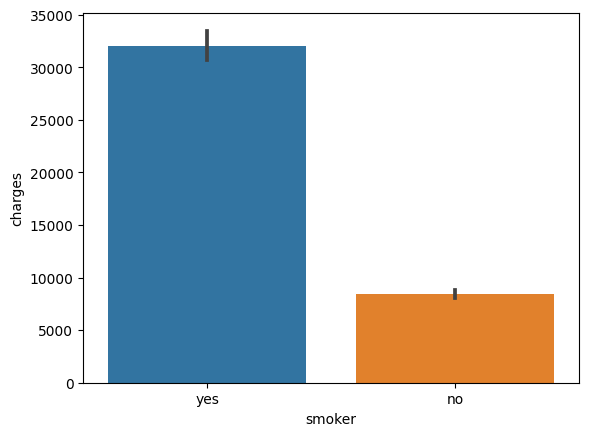

In [4]:
sns.barplot(data=df, x='smoker', y='charges');

In [5]:
# seperate smokers from non-smokers
df_smoker = df[df['smoker']=='yes']
df_nonsmoker = df[df['smoker']=='no']

# Q1. Do smokers have higher insurance charges than non-smokers?

## Stating Hypothesis

 - $H_0$: There is no difference between smokers and non smokers regarding insurance charges.

 - $H_1$: There is a difference between smokers and non-smokers in insurance charges.

Data Type : Numeric

Samples: 2 samples/groups

Test : 2 Sample T-Test

Assumptions : 
 - No significant outliers 
 - Normality 
 - Equal Variance 

In [6]:
# seperate smoker charges from non-smoker charges
smoker_charges = df_smoker['charges']
nonsmoker_charges = df_nonsmoker['charges']

print("charges for smokers", smoker_charges)
print("charges for nonsmokers", nonsmoker_charges)

charges for smokers 0       16884.92400
11      27808.72510
14      39611.75770
19      36837.46700
23      37701.87680
           ...     
1313    36397.57600
1314    18765.87545
1321    28101.33305
1323    43896.37630
1337    29141.36030
Name: charges, Length: 274, dtype: float64
charges for nonsmokers 1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1063, dtype: float64


In [7]:
# Check for outliers in smokers charges
smoker_zscores= stats.zscore(smoker_charges)
smoker_outliers = abs(smoker_zscores)>3
print(np.sum(smoker_outliers))

0


In [8]:
# Check for outliers in nonsmokers charges
non_zscores= stats.zscore(nonsmoker_charges)
non_outliers = abs(non_zscores)>3
print(np.sum(non_outliers))

24


In [9]:
# remove outliers from nonsmoker charges
print(len(nonsmoker_charges))
nonsmoker_charges = nonsmoker_charges[non_outliers == False] 
print(len(nonsmoker_charges))

1063
1039


In [10]:
# check for normality
result = stats.normaltest(smoker_charges)
result

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [11]:
# check for normality
result = stats.normaltest(nonsmoker_charges)
result


NormaltestResult(statistic=163.70821423990097, pvalue=2.8262654970074626e-36)

Both normality tests have failed which indicates that the data is not a normal distribution.

Despite both test showing a non-normal distibution we can ignore this assumption because we n>15.

In [12]:
# levenes test
result = stats.levene(smoker_charges, nonsmoker_charges)
result

LeveneResult(statistic=520.7178262969225, pvalue=2.512613039096279e-97)

We failed the equal variance test. Therefore we need to use an alternative test. 

In [13]:
result = stats.ttest_ind(smoker_charges, nonsmoker_charges, equal_var=False)
result

Ttest_indResult(statistic=33.723466247187815, pvalue=2.7282718648018296e-104)

Because p < .05 we reject the null hypothesis. 

Mean smoker charges :  32050.23183153284
Mean non-smoker charges 7945.9246538585185


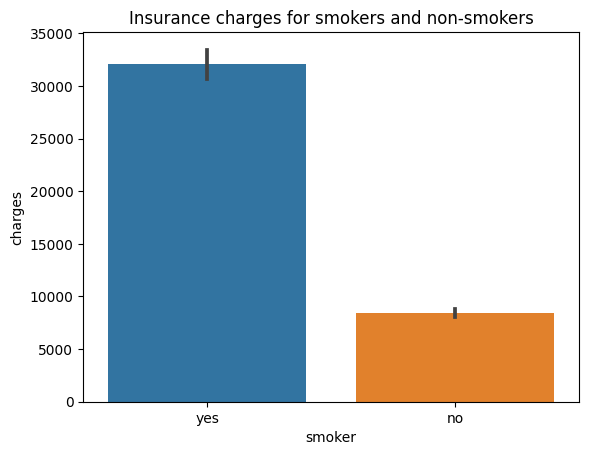

In [14]:
ax = sns.barplot(data=df, x='smoker', y='charges')
print("Mean smoker charges : ", smoker_charges.mean())
print("Mean non-smoker charges", nonsmoker_charges.mean())
ax.set_title('Insurance charges for smokers and non-smokers')
plt.savefig('Visuals/charges_barplot.png', pad_inches=1)

# Q2. Are men more likely to smoke than women?

## Stating Hypothesis
$H_0$: Men and women are equally likely to be smokers.

$H_1$: There is a difference between Men and women in there likelyhood of being a smoker. 

Data Type : Categorical

Sample : 2 samples/groups

Test : Chi-Square

Assumptions : 
 - There are two categorical variables (ordinal or nominal), And
 - Their outcomes are independent.

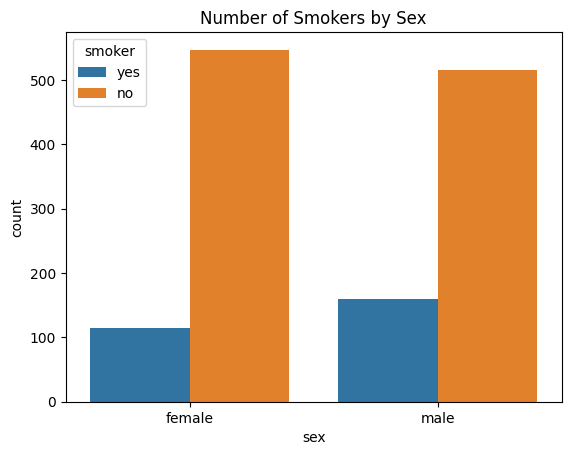

In [15]:
ax = sns.countplot(data=df, x='sex',hue='smoker')
ax.set_title("Number of Smokers by Sex");
plt.savefig('Visuals/numberofsmokers_barplot.png', pad_inches=1)

In [16]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['smoker'], df['sex'])
table

sex,female,male
smoker,,
no,547,516
yes,115,159


In [17]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results
p

0.0062765550120107375

Because we have a significant p value we reject our null hypothesis. We conclude that there is a difference between males and female smokers.
It appears that males are more likely to be smokers.

In [18]:
table = pd.crosstab(df['smoker'], df['sex'], normalize='columns')
table

sex,female,male
smoker,,
no,0.826284,0.764444
yes,0.173716,0.235556


# Q3. Do different regions have different charges, on average?

## Stating Hypothesis
$H_0$: There is no difference in charges between regions.

$H_1$: There is a difference in charges, on average, between regions.

Data Type : Numerical

Sample : More than 2 samples/groups

Test : ANOVA and/or Tukey

Assumptions : 
 - No significant outliers 
 - Equal variance 
 - Normality

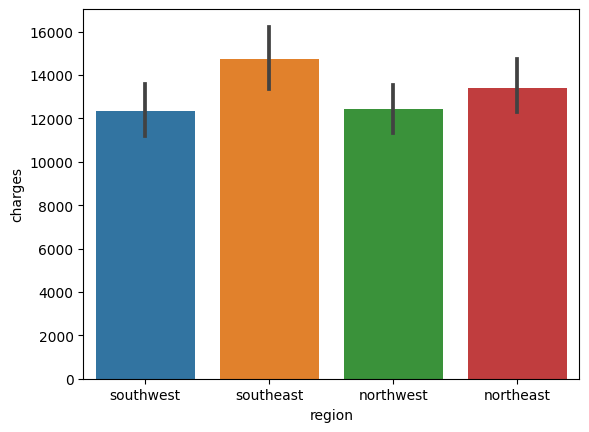

In [19]:
sns.barplot(data=df, x='region',y='charges');

In [20]:
## Create groups dictionary. 
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
    
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [21]:
clean_groups = {}

for i, j in groups.items():
    # Find the outliers 
    idx_outliers = np.abs(stats.zscore(j))>3
    
    # display how many there are
    print("\nFor region : ", i, "\nNumber of outliers : ", idx_outliers.sum())
    
    # store which rows are outliers and which aren't
    temp = j[idx_outliers==False]
    
    #combine the non-outliers with original dict
    clean_groups[i] = temp


For region :  southwest 
Number of outliers :  8

For region :  southeast 
Number of outliers :  2

For region :  northwest 
Number of outliers :  7

For region :  northeast 
Number of outliers :  4


In [22]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in clean_groups.items():
    # test
    stat, p = stats.normaltest(data)
    
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data), 'p':p, 'test stat':stat}
    
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T

### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,317.0,7.728611e-22,97.223886,True
southeast,362.0,1.936990e-13,58.544942,True
northwest,317.0,3.547435e-19,84.965784,True
northeast,320.0,3.557877e-17,75.749565,True


In [23]:
# Test
stats.levene(*groups.values())

LeveneResult(statistic=5.553479860699911, pvalue=0.0008689544824002284)

Because p < .05, we reject the null hypothesis and the data is not equal variant.

In [24]:
# perform the correct hypothesis test
result = stats.kruskal( *groups.values())
result

KruskalResult(statistic=4.622506584464645, pvalue=0.20161983372311595)

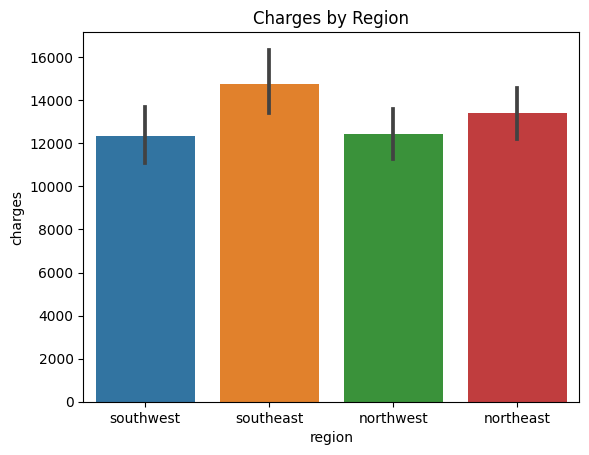

In [25]:
ax = sns.barplot(data=df, x='region',y='charges');
ax.set_title("Charges by Region")
plt.savefig('Visuals/chargesbyregion_barplot.png', pad_inches=1)

Because p > .05 we fail to reject the null hypothesis or we failed to conclude that its NOT due to random chance.